In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## The Markov Decision Process

In [2]:
ACTIONS = ["SHOOT", "DODGE", "RECHARGE"]
STAMINA = [0, 50, 100]
ARROWS = [0, 1, 2, 3]
DRAGON_HEALTH = [0, 25, 50, 75, 100]

v_table = np.zeros(shape=(5, 4, 3)) # (arrows, stamina, health)
p_table = np.zeros(shape=(5, 4, 3))
q_table = np.zeros(shape=(5, 4, 3, len(ACTIONS)))

In [3]:
STATES = [(h, a, s) for h in range(v_table.shape[0]) 
                    for a in range(v_table.shape[1]) 
                    for s in range(v_table.shape[2])]

In [4]:
INFINTIY = 1e16

def get_next_utility(state: tuple, action: int) -> float:
    """
    Computes the utility of the next state
    """
    assert len(state) == 3 and state[0] < 5 and state[1] < 4 and state[2] < 3 and action < 3
    dragon_health, arrows, stamina = state
    if dragon_health == 0:
        return 0.0
    if ACTIONS[action] == "SHOOT":
        if arrows == 0 or stamina == 0:
            return -INFINTIY
        return 0.5 * v_table[dragon_health, arrows - 1, stamina - 1] + \
               0.5 * v_table[dragon_health - 1, arrows - 1, stamina - 1]
    elif ACTIONS[action] == "DODGE":
        if stamina == 0:
            return -INFINTIY
        elif stamina == 1:
            return 0.8 * v_table[dragon_health, min(arrows + 1, 3), 0] + \
                   0.2 * v_table[dragon_health, arrows, 0]
        elif stamina == 2:
            return 0.8 * 0.8 * v_table[dragon_health, min(arrows + 1, 3), 1] + \
                   0.2 * 0.8 * v_table[dragon_health, arrows, 1] + \
                   0.8 * 0.2 * v_table[dragon_health, min(arrows + 1, 3), 0] + \
                   0.2 * 0.2 * v_table[dragon_health, arrows, 0]
    elif ACTIONS[action] == "RECHARGE":
        return 0.8 * v_table[dragon_health, arrows, min(stamina + 1, 2)] + \
               0.2 * v_table[dragon_health, arrows, stamina]

In [5]:
def check_convergence(old_table: np.ndarray, new_table: np.ndarray, delta: float = 0.001) -> bool:
    """
    Checks if the value iteration algorithm has converged
    """
    assert old_table.shape == new_table.shape
    ans = np.max(np.abs(new_table - old_table)) < delta
    return ans

In [6]:
def random_initialize():
    """
    Randomly assigns values to the v_table and the p_table
    """
    global v_table, q_table, p_table
    v_table = np.zeros(shape=v_table.shape)
    q_table = np.zeros(shape=q_table.shape)
    p_table = np.random.choice(range(len(ACTIONS)), size=p_table.shape)

In [7]:
def print_state(iteration: int, v_table: np.ndarray, p_table: np.ndarray, filename = None):
    """
    Prints the entire state in the Value Iteration Algorithm
    """
    assert len(v_table.shape) == len(p_table.shape) == 3
    if filename == None:
        print("iteration=", iteration)
        for h, a, s in STATES:
            print("({0},{1},{2}):{3}=[{4:.3f}]".format(
                h, a, s, 
                ACTIONS[p_table[h][a][s]] if h != 0 else '-1', v_table[h][a][s]))
        print("\n\n")
    else:
        with open(filename, 'a') as f:
            f.write("iteration={}\n".format(iteration))
            for h, a, s in STATES:
                f.write("({0},{1},{2}):{3}=[{4:.3f}]\n".format(
                    h, a, s, 
                    ACTIONS[p_table[h][a][s]] if h != 0 else '-1', v_table[h][a][s]))
            f.write("\n\n")

## The Value Iteration Algorithm

```
Procedure Value_Iteration(S, A, P, R, θ)
    Inputs:
        S is the set of all states
        A is the set of all actions
        P is state transition function specifying P(s'|s,a)
        R is a reward function R(s,a,s')
        θ a threshold, θ > 0$
    Output:
        π[S] approximately optimal policy
        V[S] value function
    Local:
        real array Vk[S] is a sequence of value functions
        action array π[S]
        
    assign V0[S] arbitrarily
    k ← 0
    repeat
       k ← k+1
       for each state s do
           Vk[s] = maxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk-1[s'])
    until ∀s |Vk[s]-Vk-1[s]| < θ
    for each state s do
       π[s] = argmaxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk[s'])
    return π,Vk
```

In [8]:
def value_iteration(get_action_cost, gamma: float = 0.99, delta: float = 0.001, filename = None):
    """
    Computes the Optimal Policy and the State Values
    :return history_delta: (list<float>) The change in function over the history
    """
    history_delta = []
    global v_table, p_table, q_table
    random_initialize()
    converged = False
    for iteration in range(1, 1000):
        for h, a, s in STATES:
            for act in range(len(ACTIONS)):
                q_table[h, a, s, act] = gamma * get_next_utility((h, a, s), act) \
                                              + get_action_cost((h, a, s), act)
        new_v_table = np.max(q_table, axis=3)
        p_table = np.argmax(q_table, axis=3)
        converged = check_convergence(v_table, new_v_table, delta)
        history_delta.append(np.max(np.abs(new_v_table - v_table)))
        v_table = new_v_table
        print_state(iteration, v_table, p_table, filename)
        if converged:
            break
    return history_delta.copy()

In [9]:
def get_action_cost_subtask1(state: tuple, action: int) -> float:
    """
    Returns the reward associated with each action taken
    """
    assert len(state) == 3 and state[0] < 5 and state[1] < 4 and state[2] < 3 and action < 3
    if state[0] == 0:
        return 0.0
    elif state[0] == 1 and action == 0:
        return (-2.5 if ACTIONS[action] != "SHOOT" else -0.25) + 10.0 * 0.5
    else:
        return -2.5 if ACTIONS[action] != "SHOOT" else -0.25
     
def get_action_cost_general(state: tuple, action: int) -> float:
    """
    Returns the reward associated with each action taken
    """
    assert len(state) == 3 and state[0] < 5 and state[1] < 4 and state[2] < 3 and action < 3
    if state[0] == 0:
        return 0.0
    elif state[0] == 1 and action == 0:
        return -2.5 + 10.0 * 0.5
    else:
        return -2.5

In [10]:
history_delta_1 = value_iteration(get_action_cost=get_action_cost_subtask1, filename='outputs/task_2_part_1_trace.txt')
v_table_1 = v_table.copy()
p_table_1 = p_table.copy()

In [11]:
history_delta_2 = value_iteration(get_action_cost=get_action_cost_general, gamma=0.1, filename='outputs/task_2_part_2_trace.txt')
v_table_2 = v_table.copy()
p_table_2 = p_table.copy()

In [12]:
history_delta_3 = value_iteration(get_action_cost=get_action_cost_general, gamma=0.1, delta=1e-10, filename='outputs/task_2_part_3_trace.txt')
v_table_3 = v_table.copy()
p_table_3 = p_table.copy()

## Checking our Answers

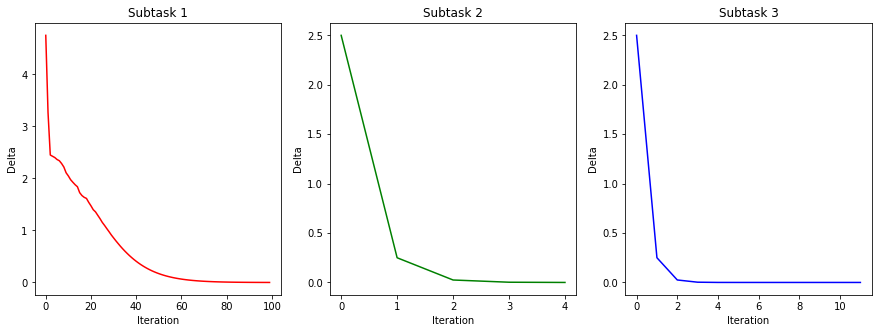

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history_delta_1, color='red')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Delta')
ax[0].set_title('Subtask 1')
ax[1].plot(history_delta_2, color='green')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Delta')
ax[1].set_title('Subtask 2')
ax[2].plot(history_delta_3, color='blue')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Delta')
ax[2].set_title('Subtask 3')
plt.show()

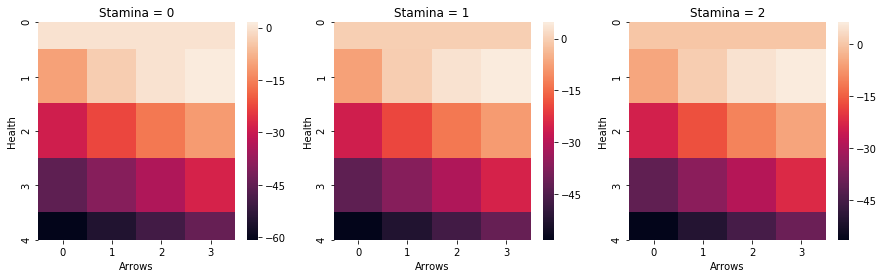

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(v_table_1[:, :, 0], ax=ax[0])
ax[0].set_title('Stamina = 0')
ax[0].set_xlabel('Arrows')
ax[0].set_ylabel('Health')
sns.heatmap(v_table_1[:, :, 1], ax=ax[1])
ax[1].set_title('Stamina = 1')
ax[1].set_xlabel('Arrows')
ax[1].set_ylabel('Health')
sns.heatmap(v_table_1[:, :, 2], ax=ax[2])
ax[2].set_title('Stamina = 2')
ax[2].set_xlabel('Arrows')
ax[2].set_ylabel('Health')
plt.show()

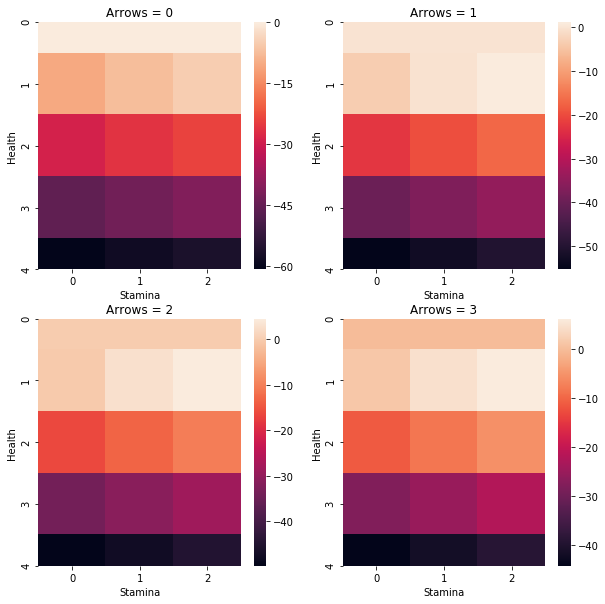

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(v_table_1[:, 0, :], ax=ax[0][0])
ax[0][0].set_title('Arrows = 0')
ax[0][0].set_xlabel('Stamina')
ax[0][0].set_ylabel('Health')
sns.heatmap(v_table_1[:, 1, :], ax=ax[0][1])
ax[0][1].set_title('Arrows = 1')
ax[0][1].set_xlabel('Stamina')
ax[0][1].set_ylabel('Health')
sns.heatmap(v_table_1[:, 2, :], ax=ax[1][0])
ax[1][0].set_title('Arrows = 2')
ax[1][0].set_xlabel('Stamina')
ax[1][0].set_ylabel('Health')
sns.heatmap(v_table_1[:, 3, :], ax=ax[1][1])
ax[1][1].set_title('Arrows = 3')
ax[1][1].set_xlabel('Stamina')
ax[1][1].set_ylabel('Health')

plt.show()

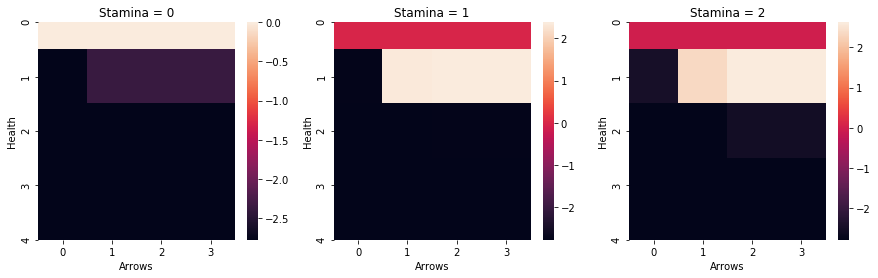

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(v_table_2[:, :, 0], ax=ax[0])
ax[0].set_title('Stamina = 0')
ax[0].set_xlabel('Arrows')
ax[0].set_ylabel('Health')
sns.heatmap(v_table_2[:, :, 1], ax=ax[1])
ax[1].set_title('Stamina = 1')
ax[1].set_xlabel('Arrows')
ax[1].set_ylabel('Health')
sns.heatmap(v_table_2[:, :, 2], ax=ax[2])
ax[2].set_title('Stamina = 2')
ax[2].set_xlabel('Arrows')
ax[2].set_ylabel('Health')
plt.show()

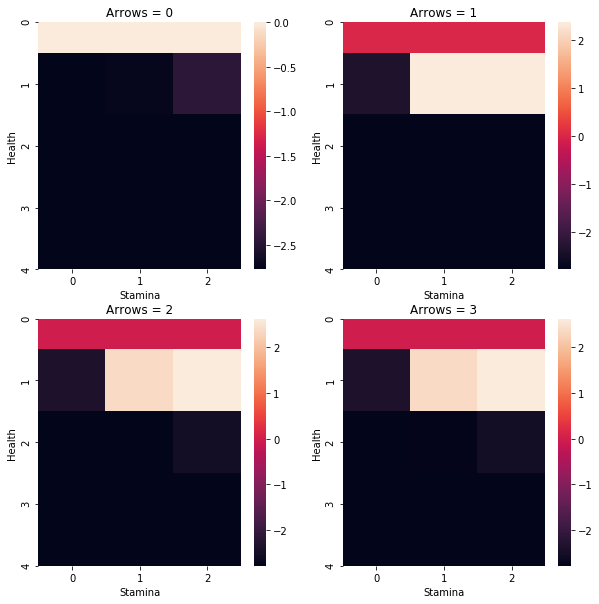

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(v_table_2[:, 0, :], ax=ax[0][0])
ax[0][0].set_title('Arrows = 0')
ax[0][0].set_xlabel('Stamina')
ax[0][0].set_ylabel('Health')
sns.heatmap(v_table_2[:, 1, :], ax=ax[0][1])
ax[0][1].set_title('Arrows = 1')
ax[0][1].set_xlabel('Stamina')
ax[0][1].set_ylabel('Health')
sns.heatmap(v_table_2[:, 2, :], ax=ax[1][0])
ax[1][0].set_title('Arrows = 2')
ax[1][0].set_xlabel('Stamina')
ax[1][0].set_ylabel('Health')
sns.heatmap(v_table_2[:, 3, :], ax=ax[1][1])
ax[1][1].set_title('Arrows = 3')
ax[1][1].set_xlabel('Stamina')
ax[1][1].set_ylabel('Health')

plt.show()

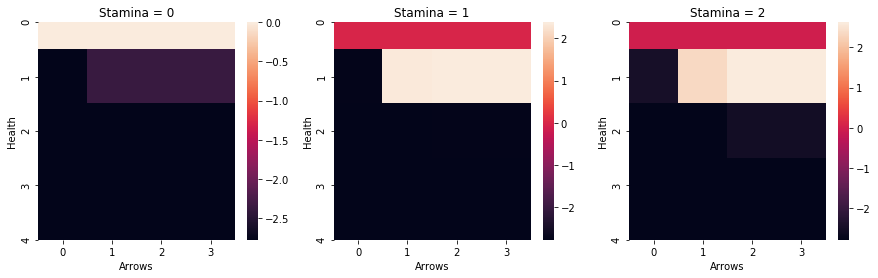

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(v_table_3[:, :, 0], ax=ax[0])
ax[0].set_title('Stamina = 0')
ax[0].set_xlabel('Arrows')
ax[0].set_ylabel('Health')
sns.heatmap(v_table_3[:, :, 1], ax=ax[1])
ax[1].set_title('Stamina = 1')
ax[1].set_xlabel('Arrows')
ax[1].set_ylabel('Health')
sns.heatmap(v_table_3[:, :, 2], ax=ax[2])
ax[2].set_title('Stamina = 2')
ax[2].set_xlabel('Arrows')
ax[2].set_ylabel('Health')
plt.show()

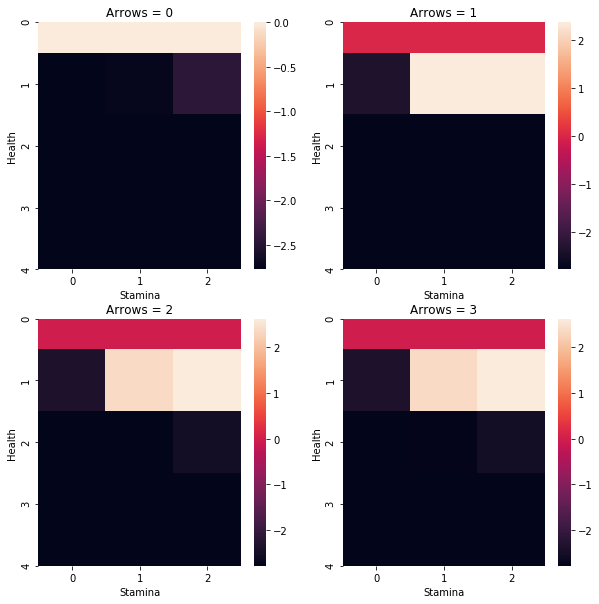

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(v_table_3[:, 0, :], ax=ax[0][0])
ax[0][0].set_title('Arrows = 0')
ax[0][0].set_xlabel('Stamina')
ax[0][0].set_ylabel('Health')
sns.heatmap(v_table_3[:, 1, :], ax=ax[0][1])
ax[0][1].set_title('Arrows = 1')
ax[0][1].set_xlabel('Stamina')
ax[0][1].set_ylabel('Health')
sns.heatmap(v_table_3[:, 2, :], ax=ax[1][0])
ax[1][0].set_title('Arrows = 2')
ax[1][0].set_xlabel('Stamina')
ax[1][0].set_ylabel('Health')
sns.heatmap(v_table_3[:, 3, :], ax=ax[1][1])
ax[1][1].set_title('Arrows = 3')
ax[1][1].set_xlabel('Stamina')
ax[1][1].set_ylabel('Health')

plt.show()

## Final Observations

### Subtask 1: New Step Rewards

The Convergence of this function is much faster than was before (in task 1), the lowered step costs and the favored shoot action allows the model to learn the kill technique much faster, which it later slowly changes to better action combinations involving dodge and recharge, improving the score further. There is more incentive to be greedy and shoot at the beginning.

### Subtask 2: The High Future Discount

The huge discount factor **kills the incentive** to look and try to get the big reward (killing the dragon) in the future. The agent will only look 1 move deep and *only try if the dragon has health 25 and it has both arrows and stamina*, otherwise it will give up. All moves / futures look relatively equal. 

### Subtask 3: Complete Convergence

This change has no effect as compared to Subtask 2, since the agent has already almost completely discounted the future. The policy will not change as we hone down more on the utility values as the agent himself does not value anything in the future, changing convergence ($\delta$) to $10^-3$ to $10^-10$ are both almost equally good. It just takes a few more iterations to get there. 

**Results of Part 1**
```
iteration=100
(0,0,0):-1=[0.000]
(0,0,1):-1=[0.000]
(0,0,2):-1=[0.000]
(0,1,0):-1=[0.000]
(0,1,1):-1=[0.000]
(0,1,2):-1=[0.000]
(0,2,0):-1=[0.000]
(0,2,1):-1=[0.000]
(0,2,2):-1=[0.000]
(0,3,0):-1=[0.000]
(0,3,1):-1=[0.000]
(0,3,2):-1=[0.000]
(1,0,0):RECHARGE=[-10.317]
(1,0,1):DODGE=[-7.291]
(1,0,2):DODGE=[-4.839]
(1,1,0):RECHARGE=[-3.470]
(1,1,1):SHOOT=[-0.357]
(1,1,2):SHOOT=[1.141]
(1,2,0):RECHARGE=[-0.123]
(1,2,1):SHOOT=[3.032]
(1,2,2):SHOOT=[4.573]
(1,3,0):RECHARGE=[1.514]
(1,3,1):SHOOT=[4.689]
(1,3,2):SHOOT=[6.251]
(2,0,0):RECHARGE=[-28.809]
(2,0,1):DODGE=[-26.016]
(2,0,2):DODGE=[-23.754]
(2,1,0):RECHARGE=[-22.490]
(2,1,1):SHOOT=[-19.617]
(2,1,2):SHOOT=[-16.737]
(2,2,0):RECHARGE=[-16.054]
(2,2,1):SHOOT=[-13.100]
(2,2,2):SHOOT=[-10.137]
(2,3,0):RECHARGE=[-11.272]
(2,3,1):SHOOT=[-8.257]
(2,3,2):SHOOT=[-5.233]
(3,0,0):RECHARGE=[-45.556]
(3,0,1):DODGE=[-42.975]
(3,0,2):DODGE=[-40.884]
(3,1,0):RECHARGE=[-39.716]
(3,1,1):SHOOT=[-37.061]
(3,1,2):SHOOT=[-34.400]
(3,2,0):RECHARGE=[-33.772]
(3,2,1):SHOOT=[-31.042]
(3,2,2):SHOOT=[-28.306]
(3,3,0):RECHARGE=[-27.720]
(3,3,1):SHOOT=[-24.914]
(3,3,2):SHOOT=[-22.100]
(4,0,0):RECHARGE=[-60.717]
(4,0,1):DODGE=[-58.328]
(4,0,2):DODGE=[-56.393]
(4,1,0):RECHARGE=[-55.312]
(4,1,1):SHOOT=[-52.855]
(4,1,2):SHOOT=[-50.395]
(4,2,0):RECHARGE=[-49.815]
(4,2,1):SHOOT=[-47.288]
(4,2,2):SHOOT=[-44.758]
(4,3,0):RECHARGE=[-44.223]
(4,3,1):SHOOT=[-41.625]
(4,3,2):SHOOT=[-39.023]
```

**Result of Part 2**
```
iteration=5
(0,0,0):-1=[0.000]
(0,0,1):-1=[0.000]
(0,0,2):-1=[0.000]
(0,1,0):-1=[0.000]
(0,1,1):-1=[0.000]
(0,1,2):-1=[0.000]
(0,2,0):-1=[0.000]
(0,2,1):-1=[0.000]
(0,2,2):-1=[0.000]
(0,3,0):-1=[0.000]
(0,3,1):-1=[0.000]
(0,3,2):-1=[0.000]
(1,0,0):RECHARGE=[-2.775]
(1,0,1):DODGE=[-2.744]
(1,0,2):DODGE=[-2.442]
(1,1,0):RECHARGE=[-2.358]
(1,1,1):SHOOT=[2.361]
(1,1,2):SHOOT=[2.363]
(1,2,0):RECHARGE=[-2.357]
(1,2,1):SHOOT=[2.382]
(1,2,2):SHOOT=[2.618]
(1,3,0):RECHARGE=[-2.357]
(1,3,1):SHOOT=[2.382]
(1,3,2):SHOOT=[2.619]
(2,0,0):RECHARGE=[-2.778]
(2,0,1):DODGE=[-2.778]
(2,0,2):DODGE=[-2.778]
(2,1,0):RECHARGE=[-2.778]
(2,1,1):SHOOT=[-2.778]
(2,1,2):SHOOT=[-2.776]
(2,2,0):RECHARGE=[-2.776]
(2,2,1):SHOOT=[-2.757]
(2,2,2):SHOOT=[-2.521]
(2,3,0):RECHARGE=[-2.776]
(2,3,1):SHOOT=[-2.757]
(2,3,2):SHOOT=[-2.519]
(3,0,0):RECHARGE=[-2.778]
(3,0,1):DODGE=[-2.778]
(3,0,2):DODGE=[-2.778]
(3,1,0):RECHARGE=[-2.778]
(3,1,1):SHOOT=[-2.778]
(3,1,2):SHOOT=[-2.778]
(3,2,0):RECHARGE=[-2.778]
(3,2,1):SHOOT=[-2.778]
(3,2,2):SHOOT=[-2.778]
(3,3,0):RECHARGE=[-2.778]
(3,3,1):SHOOT=[-2.778]
(3,3,2):SHOOT=[-2.777]
(4,0,0):RECHARGE=[-2.778]
(4,0,1):DODGE=[-2.778]
(4,0,2):DODGE=[-2.778]
(4,1,0):RECHARGE=[-2.778]
(4,1,1):SHOOT=[-2.778]
(4,1,2):SHOOT=[-2.778]
(4,2,0):RECHARGE=[-2.778]
(4,2,1):SHOOT=[-2.778]
(4,2,2):SHOOT=[-2.778]
(4,3,0):RECHARGE=[-2.778]
(4,3,1):SHOOT=[-2.778]
(4,3,2):SHOOT=[-2.778]
```

**Result of Part 3**
```
iteration=12
(0,0,0):-1=[0.000]
(0,0,1):-1=[0.000]
(0,0,2):-1=[0.000]
(0,1,0):-1=[0.000]
(0,1,1):-1=[0.000]
(0,1,2):-1=[0.000]
(0,2,0):-1=[0.000]
(0,2,1):-1=[0.000]
(0,2,2):-1=[0.000]
(0,3,0):-1=[0.000]
(0,3,1):-1=[0.000]
(0,3,2):-1=[0.000]
(1,0,0):RECHARGE=[-2.775]
(1,0,1):DODGE=[-2.744]
(1,0,2):DODGE=[-2.442]
(1,1,0):RECHARGE=[-2.358]
(1,1,1):SHOOT=[2.361]
(1,1,2):SHOOT=[2.363]
(1,2,0):RECHARGE=[-2.357]
(1,2,1):SHOOT=[2.382]
(1,2,2):SHOOT=[2.618]
(1,3,0):RECHARGE=[-2.357]
(1,3,1):SHOOT=[2.382]
(1,3,2):SHOOT=[2.619]
(2,0,0):RECHARGE=[-2.778]
(2,0,1):DODGE=[-2.778]
(2,0,2):DODGE=[-2.778]
(2,1,0):RECHARGE=[-2.778]
(2,1,1):SHOOT=[-2.778]
(2,1,2):SHOOT=[-2.776]
(2,2,0):RECHARGE=[-2.776]
(2,2,1):SHOOT=[-2.757]
(2,2,2):SHOOT=[-2.521]
(2,3,0):RECHARGE=[-2.776]
(2,3,1):SHOOT=[-2.757]
(2,3,2):SHOOT=[-2.519]
(3,0,0):RECHARGE=[-2.778]
(3,0,1):DODGE=[-2.778]
(3,0,2):DODGE=[-2.778]
(3,1,0):RECHARGE=[-2.778]
(3,1,1):SHOOT=[-2.778]
(3,1,2):SHOOT=[-2.778]
(3,2,0):RECHARGE=[-2.778]
(3,2,1):SHOOT=[-2.778]
(3,2,2):SHOOT=[-2.778]
(3,3,0):RECHARGE=[-2.778]
(3,3,1):SHOOT=[-2.778]
(3,3,2):SHOOT=[-2.777]
(4,0,0):RECHARGE=[-2.778]
(4,0,1):DODGE=[-2.778]
(4,0,2):DODGE=[-2.778]
(4,1,0):RECHARGE=[-2.778]
(4,1,1):SHOOT=[-2.778]
(4,1,2):SHOOT=[-2.778]
(4,2,0):RECHARGE=[-2.778]
(4,2,1):SHOOT=[-2.778]
(4,2,2):SHOOT=[-2.778]
(4,3,0):RECHARGE=[-2.778]
(4,3,1):SHOOT=[-2.778]
(4,3,2):SHOOT=[-2.778]
```